In [146]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [147]:
csv_path = Path("../data/raw/online_retail_II.csv")
df = pd.read_csv(csv_path)

In [148]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### RAW EDA 

In [149]:
df.shape

(1067371, 8)

In [150]:
df.columns.tolist()

['Invoice',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'Price',
 'Customer ID',
 'Country']

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [152]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [153]:
df.duplicated().sum()

np.int64(34335)

In [154]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [155]:
# Zakres dat + liczby unikalnych bytów
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["Quantity"]    = pd.to_numeric(df["Quantity"], errors="coerce")
df["Price"]       = pd.to_numeric(df["Price"], errors="coerce")

df["InvoiceDate"].min(), df["InvoiceDate"].max(), df["Country"].nunique(), df["Invoice"].nunique(), df["StockCode"].nunique(), df["Customer ID"].nunique()

(Timestamp('2009-12-01 07:45:00'),
 Timestamp('2011-12-09 12:50:00'),
 43,
 53628,
 5305,
 5942)

In [156]:
neg_qty   = (df["Quantity"] < 0).sum()        # zwroty
zero_qty  = (df["Quantity"] == 0).sum()
zero_price= (df["Price"] == 0).sum()
neg_qty, zero_qty, zero_price

(np.int64(22950), np.int64(0), np.int64(6202))

### RAW EDA -> WNIOSKI

**Struktura i skala**
- Tabela ma ~1.06 mln wierszy i 8 kolumn (transakcje pozycji).
- Kluczowe kolumny: `Invoice` (ID faktury), `StockCode` (SKU), `Description`, `Quantity`, `InvoiceDate`, `Price`, `Customer ID`, `Country`.

**Jakość danych (na surowo)**
- Typy wymagają konwersji: `InvoiceDate` jest typu obiekt – trzeba zamienić na `datetime`; `Quantity`/`Price` na numeryczne.
- Najwięcej braków ma `Customer ID` (anonimowe zakupy = `243007`), oraz `Description` (opis = `4382`), reszta bez braków.
- Duplikaty pełnych wierszy: niewielka liczba (akceptowalne), ale warto mieć to na oku w dalszych krokach.

**Anomalie biznesowe / techniczne**
- `Quantity` ma wartości ujemne → interpretujemy je jako **zwroty**.
- `Price` bywa równe 0 lub ≤0 – takie rekordy usuniemy w etapie czyszczenia.
- Warto utrzymywać logikę „pozycji zamówienia”: z `Quantity * Price` zbudujemy `Amount` (wartość pozycji).

**Zakres i unikalności (orientacyjnie)**
- Zakres dat: `2009-12-01 07:45:00` → `2011-12-09 12:50:00` (uzupełnij po sprawdzeniu).
- Krajów: `43`, unikalnych faktur: `53628`, unikalnych produktów (SKU): `5305`.
- Unikalni klienci: `5942` (część `Customer ID` pusta → klienci niezidentyfikowani).

**Decyzje na dalsze kroki**
1. Konwersje typów (`InvoiceDate`→datetime; `Quantity`/`Price`→numeric).
2. Dodanie cech: `Amount = Quantity * Price`, `IsReturn = Quantity < 0`.
3. Filtry jakości: usunąć `Price <= 0`, `Quantity == 0`, rekordy bez daty.
4. Zapisać wersję „processed” + raport braków (`reports/dq_summary.csv`).
5. Na **processed** zrobić właściwą EDA (histogramy, top produkty, trend dzienny).


### CLEANING

In [157]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

df[['InvoiceDate', 'Quantity', 'Price']].dtypes

InvoiceDate    datetime64[ns]
Quantity                int64
Price                 float64
dtype: object

In [158]:
df['Amount'] = df['Quantity'].fillna(0) * df['Price'].fillna(0.0)
df['IsReturn'] = df['Quantity'] < 0

df[['Quantity', 'Price', 'Amount', 'IsReturn']].head()

,Quantity,Price,Amount,IsReturn
0,12,6.95,83.4,False
1,12,6.75,81.0,False
2,12,6.75,81.0,False
3,48,2.10,100.8,False
4,24,1.25,30.0,False


In [159]:
before = len(df)

df = df[(df['Price'] > 0) & (df['Quantity'] != 0) & (df['InvoiceDate'].notna())]
after = len(df)

removed = before - after
before, after, removed

(1067371, 1061164, 6207)

In [160]:
dq = (df.isna().mean().mul(100)
      .round(2)
      .sort_values(ascending=False)
      .to_frame('pct_missing'))
dq

,pct_missing
Customer ID,22.32
Invoice,0.00
StockCode,0.00
Description,0.00
InvoiceDate,0.00
Quantity,0.00
Price,0.00
Country,0.00
Amount,0.00
IsReturn,0.00


In [161]:
# zwroty
n_total   = len(df)
n_returns = int(df["IsReturn"].sum())
pct_returns = round(100 * n_returns / n_total, 2)

# braki Customer ID
n_cust_na   = int(df["Customer ID"].isna().sum())
pct_cust_na = round(100 * n_cust_na / n_total, 2)

# sprzedaż brutto / zwroty / netto (waluta wg danych – najczęściej GBP)
gross_sales     = float(df.loc[~df["IsReturn"], "Amount"].sum())
returns_amount  = float(df.loc[ df["IsReturn"], "Amount"].sum())  # ujemne
net_sales       = gross_sales + returns_amount
returns_rate_pct = round(-returns_amount / gross_sales * 100, 2) if gross_sales else 0

n_total, n_returns, pct_returns, n_cust_na, pct_cust_na, gross_sales, returns_amount, net_sales, returns_rate_pct


(1061164,
 19493,
 1.84,
 236871,
 22.32,
 20972968.138,
 -1527041.43,
 19445926.708,
 7.28)

**Podsumowanie po czyszczeniu**
- Pozycje: 1,061,164  
- Zwroty: 19,493 (1.84% pozycji)  
- Customer ID brak: 236,871 (22.32%)  
- Sprzedaż brutto: 20,972,968.14  
- Zwroty (wartość): -1,527,041.43  
- Sprzedaż netto: 19,445,926.71  
- Udział zwrotów w wartości: 7.28%


In [162]:
# Raport braków (po czyszczeniu) — poprawiona etykieta kolumny
dq = (df.isna().mean().mul(100)
        .round(2)
        .sort_values(ascending=False)
        .to_frame("pct_missing"))

Path("../reports").mkdir(parents=True, exist_ok=True)
dq.to_csv("../reports/dq_summary.csv")

# Zapis czystych danych
Path("../data/processed").mkdir(parents=True, exist_ok=True)
df.to_csv("../data/processed/dataset.csv", index=False)

### STATYSTYKA

In [163]:
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return outliers

In [164]:
out_df = identify_outliers(df, "Amount")           # zwraca DF z outlierami
df['IsOutlier_Amount'] = df.index.isin(out_df.index)
df['IsOutlier_Amount']

0           True
1           True
2           True
3           True
4          False
           ...  
1067366    False
1067367    False
1067368    False
1067369    False
1067370    False
Name: IsOutlier_Amount, Length: 1061164, dtype: bool

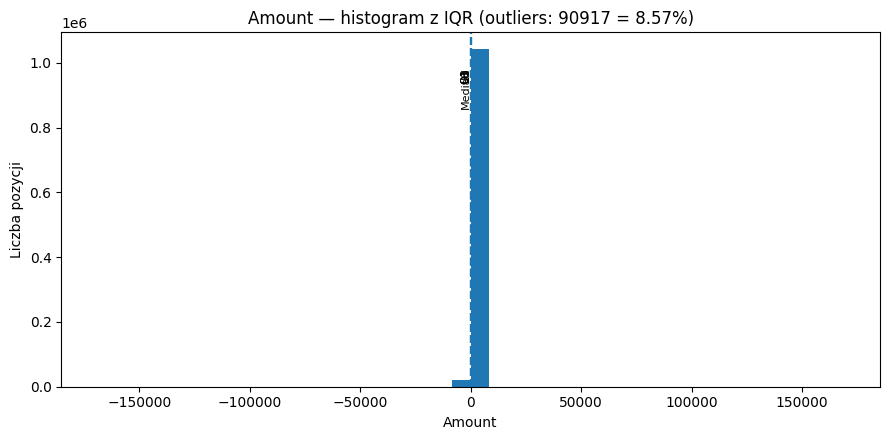

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
Path("../reports").mkdir(parents=True, exist_ok=True)

# 1) outliery Twoją funkcją -> kolumna True/False
out_df = identify_outliers(df, "Amount")           # zwraca DF z outlierami
df["IsOutlier_Amount"] = df.index.isin(out_df.index)

# 2) staty do adnotacji
Q1 = df["Amount"].quantile(0.25)
Q3 = df["Amount"].quantile(0.75)
IQR = Q3 - Q1
LO = Q1 - 1.5*IQR
HI = Q3 + 1.5*IQR
MED = df["Amount"].median()
n_out = int(df["IsOutlier_Amount"].sum())
pct_out = round(100*n_out/len(df), 2)

# 3) histogram z liniami referencyjnymi
fig, ax = plt.subplots(figsize=(9,4.5))
ax.hist(df["Amount"].dropna(), bins=40)
for x, lbl in [(LO,"LO"), (Q1,"Q1"), (MED,"Median"), (Q3,"Q3"), (HI,"HI")]:
    ax.axvline(x, linestyle="--")
    ax.text(x, ax.get_ylim()[1]*0.9, lbl, rotation=90, va="top", ha="right", fontsize=8)
ax.set_title(f"Amount — histogram z IQR (outliers: {n_out} = {pct_out}%)")
ax.set_xlabel("Amount"); ax.set_ylabel("Liczba pozycji")
fig.tight_layout(); fig.savefig("../reports/fig_stat_hist_amount_iqr.png", dpi=300); plt.show()


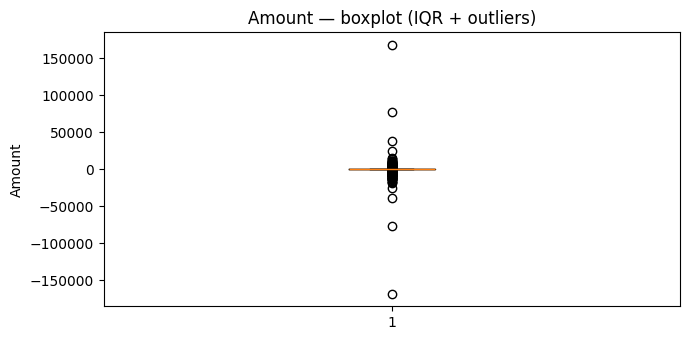

In [166]:
fig, ax = plt.subplots(figsize=(7,3.5))
ax.boxplot(df["Amount"].dropna(), vert=True, showfliers=True)
ax.set_title("Amount — boxplot (IQR + outliers)")
ax.set_ylabel("Amount")
fig.tight_layout(); fig.savefig("../reports/fig_stat_box_amount.png", dpi=300); 
plt.show()


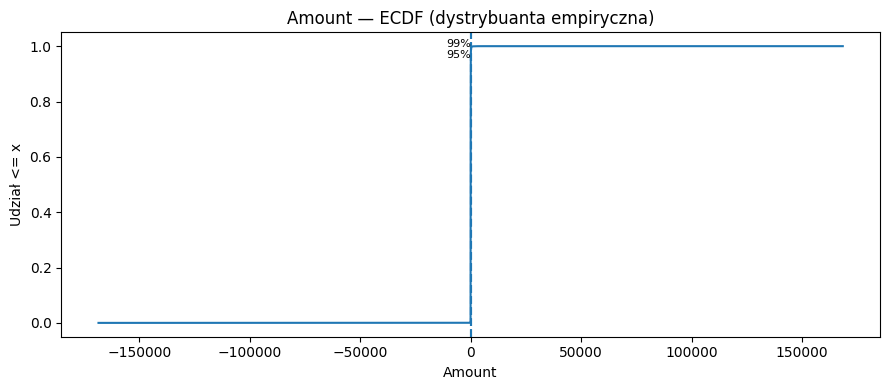

In [167]:
vals = np.sort(df["Amount"].dropna().values)
ecdf = np.arange(1, vals.size+1) / vals.size

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(vals, ecdf)
ax.set_title("Amount — ECDF (dystrybuanta empiryczna)")
ax.set_xlabel("Amount"); ax.set_ylabel("Udział <= x")
# linie pomocnicze 0.95 i 0.99
for q, lbl in [(0.95,"95%"), (0.99,"99%")]:
    xq = np.quantile(vals, q)
    ax.axvline(xq, linestyle="--"); ax.text(xq, q, lbl, fontsize=8, va="bottom", ha="right")
fig.tight_layout(); fig.savefig("../reports/fig_stat_ecdf_amount.png", dpi=300); plt.show()


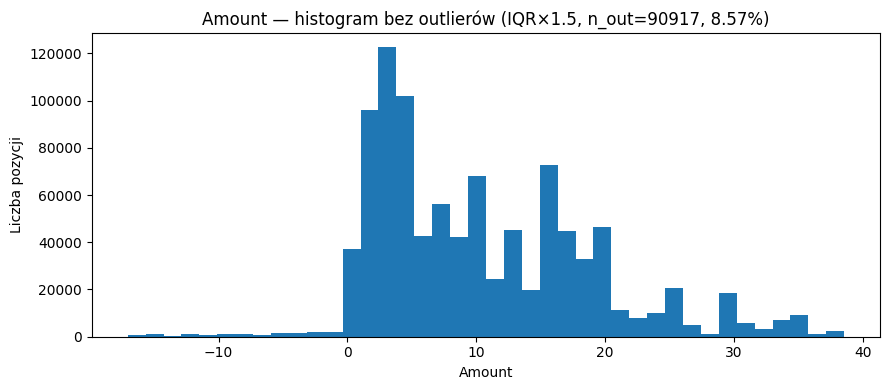

In [169]:
df_no = df.loc[~df["IsOutlier_Amount"]]
fig, ax = plt.subplots(figsize=(9,4))
ax.hist(df_no["Amount"].dropna(), bins=40)
ax.set_title(f"Amount — histogram bez outlierów (IQR×1.5, n_out={n_out}, {pct_out}%)")
ax.set_xlabel("Amount"); ax.set_ylabel("Liczba pozycji")
fig.tight_layout(); fig.savefig("../reports/fig_stat_hist_amount_no_out.png", dpi=300); plt.show()


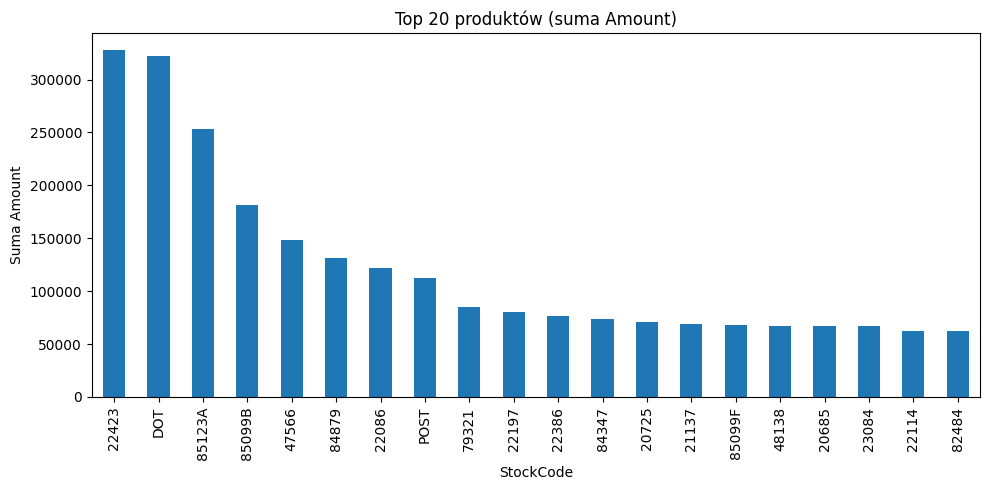

StockCode
22423     327813.65
DOT       322647.47
85123A    253720.02
85099B    181278.51
47566     147948.50
84879     131413.85
22086     121662.14
POST      112341.00
79321      84854.16
22197      80300.07
Name: Amount, dtype: float64

In [170]:
# agregacja: suma wartości sprzedaży per produkt (SKU)
top = (df.groupby("StockCode")["Amount"]
         .sum()
         .sort_values(ascending=False)
         .head(20))

# zapis tabelki pomocniczej (możesz podejrzeć w git)
Path("../reports").mkdir(parents=True, exist_ok=True)
top.to_csv("../reports/top20_products_amount.csv")

# wykres słupkowy
fig, ax = plt.subplots(figsize=(10,5))
top.plot(kind="bar", ax=ax)
ax.set_title("Top 20 produktów (suma Amount)")
ax.set_xlabel("StockCode")
ax.set_ylabel("Suma Amount")
fig.tight_layout()
fig.savefig("../reports/fig_02_bar_top_products.png", dpi=300)
plt.show()

top.head(10)  # szybki podgląd pierwszych 10 dla interpretacji